In [118]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector

from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,roc_auc_score

import warnings
warnings.simplefilter('ignore')

In [119]:
def model_basic(x_train, y_train, x_test, y_test):
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier(),
        
    ]

    rdict = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'auc_score': []}

    for clf in models:
        clf = clf.fit(x_train, y_train)
        pred = clf.predict(x_test)
        pred_prob_rf = clf.predict_proba(x_test)[:, 1].reshape(-1, 1)
        auc_score = roc_auc_score(y_test, pred_prob_rf)
        results = (
            round(accuracy_score(y_test, pred), 4),
            round(precision_score(y_test, pred), 4),
            round(recall_score(y_test, pred), 4),
            round(f1_score(y_test, pred), 4),
            round(auc_score, 4)
        )

        rdict['model'].append(clf)
        rdict['accuracy'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['auc_score'].append(results[4])

        confusion = confusion_matrix(y_test, pred)
        print(confusion)

    rdf = pd.DataFrame(data=rdict)
    return rdf

In [120]:
train = pd.read_csv('./datasets/통계검증완료/코스닥_standard_train.csv',index_col=0)
test =  pd.read_csv('./datasets/통계검증완료/코스닥_standard_test.csv',index_col=0)


---
# 산업별 더미변수 - 제조업,건설업,정보통신업,그외
---

In [121]:
# train.loc[~(train['산업군'].str.contains('제조업') | train['산업군'].str.contains('건설업') | train['산업군'].str.contains('정보통신업')), '산업군'] = '그 외'
# dummy_df = pd.get_dummies(train['산업군'])
# train = pd.concat([train,dummy_df],axis=1)

In [122]:
# test.loc[~(test['산업군'].str.contains('제조업') | test['산업군'].str.contains('건설업') | test['산업군'].str.contains('정보통신업')), '산업군'] = '그 외'
# dummy_df = pd.get_dummies(test['산업군'])
# test = pd.concat([test,dummy_df],axis=1)

----

In [123]:
train.columns

Index(['회사명', '거래소코드', '회계년도', '산업군', '총자본순이익률', 'EBIT/총자산', '총자본정상영업이익률',
       '현금흐름 대 자산', '현금흐름/총부채비율', '차입금의존도', '현금흐름 대 매출액', '순운전자본비율', '타인자본회전률',
       'EBITDA마진율', 'abs(영업현금흐름-당기순이익)/매출액', '누적수익성비율', '총자본회전률', '금융비용부담률',
       '당기전기영업손익', '자본금회전률', '영업현금흐름-단기차입금', 'FINDEP', '총자본증가율', '자기자본증가율',
       'TMD', '매출액총이익률', '매출액증가율', '자기자본순이익률', '정상영업이익증가율', 'ROA변화율', '대주주지분율',
       '외국인지분율', '이자부담률', 'target_1', 'target_2', 'target_3'],
      dtype='object')

In [124]:
col_int = [ '총자본순이익률', 'EBIT/총자산', '총자본정상영업이익률',
       '현금흐름 대 자산', '현금흐름/총부채비율', '차입금의존도', '현금흐름 대 매출액', '순운전자본비율', '타인자본회전률',
       'EBITDA마진율', 'abs(영업현금흐름-당기순이익)/매출액', '누적수익성비율', '총자본회전률', '금융비용부담률',
       '당기전기영업손익', '자본금회전률', '영업현금흐름-단기차입금', 'FINDEP', '총자본증가율', '자기자본증가율',
       'TMD', '매출액총이익률', '매출액증가율', '자기자본순이익률', '정상영업이익증가율', 'ROA변화율', '대주주지분율',
       '외국인지분율', '이자부담률']

---
#target1
---

In [125]:
x_train = train[col_int]
y_train = train[['target_1']]

x_test = test[col_int]
y_test = test[['target_1']]

In [126]:
y_test.value_counts()

target_1
0           2811
1             75
dtype: int64

In [127]:
#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select.index = x_train.columns

---
# lasso - 임베디드기법
---

In [128]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select["lasso_0.1"] = selector.get_support()


---
# stepwise - 래퍼기법
---

In [129]:
# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['logit_bwd'] = selector.get_support().tolist()

In [130]:
# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select['lda_bwd'] = selector.get_support().tolist()

---
## 비모수적 방법
---

In [131]:
# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select['RFC_bwd'] = selector.get_support().tolist()

---
## 최종 select
---

In [132]:
for col in df_select.columns.to_list():
    df_select[col] = df_select[col].apply(lambda x : 1 if x==True else 0)
df_select['total'] = df_select.sum(axis=1)
df_select[df_select['total']>=5].index

Index(['EBIT/총자산', '현금흐름 대 자산', '순운전자본비율', 'abs(영업현금흐름-당기순이익)/매출액', '누적수익성비율',
       '금융비용부담률', '당기전기영업손익', 'TMD'],
      dtype='object')

In [133]:
df_select[df_select['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
EBIT/총자산,0,1,1,1,1,1,1,6
현금흐름 대 자산,0,1,1,1,1,1,1,6
순운전자본비율,0,1,1,1,0,1,1,5
abs(영업현금흐름-당기순이익)/매출액,1,1,1,1,1,1,1,7
누적수익성비율,1,1,1,1,1,1,1,7
금융비용부담률,1,1,1,1,1,0,0,5
당기전기영업손익,0,1,1,1,1,1,0,5
TMD,1,1,1,1,1,1,1,7


In [134]:
최종_col =df_select[df_select['total']>=5].index.to_list()

# temp = ['EBIT/총자산', 'TMD', 'EBITDA마진율', '누적수익성비율', 'abs(영업현금흐름-당기순이익)/매출액', '순운전자본비율','당기전기영업손익']
x_train_1 = x_train[최종_col]
x_test_1 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

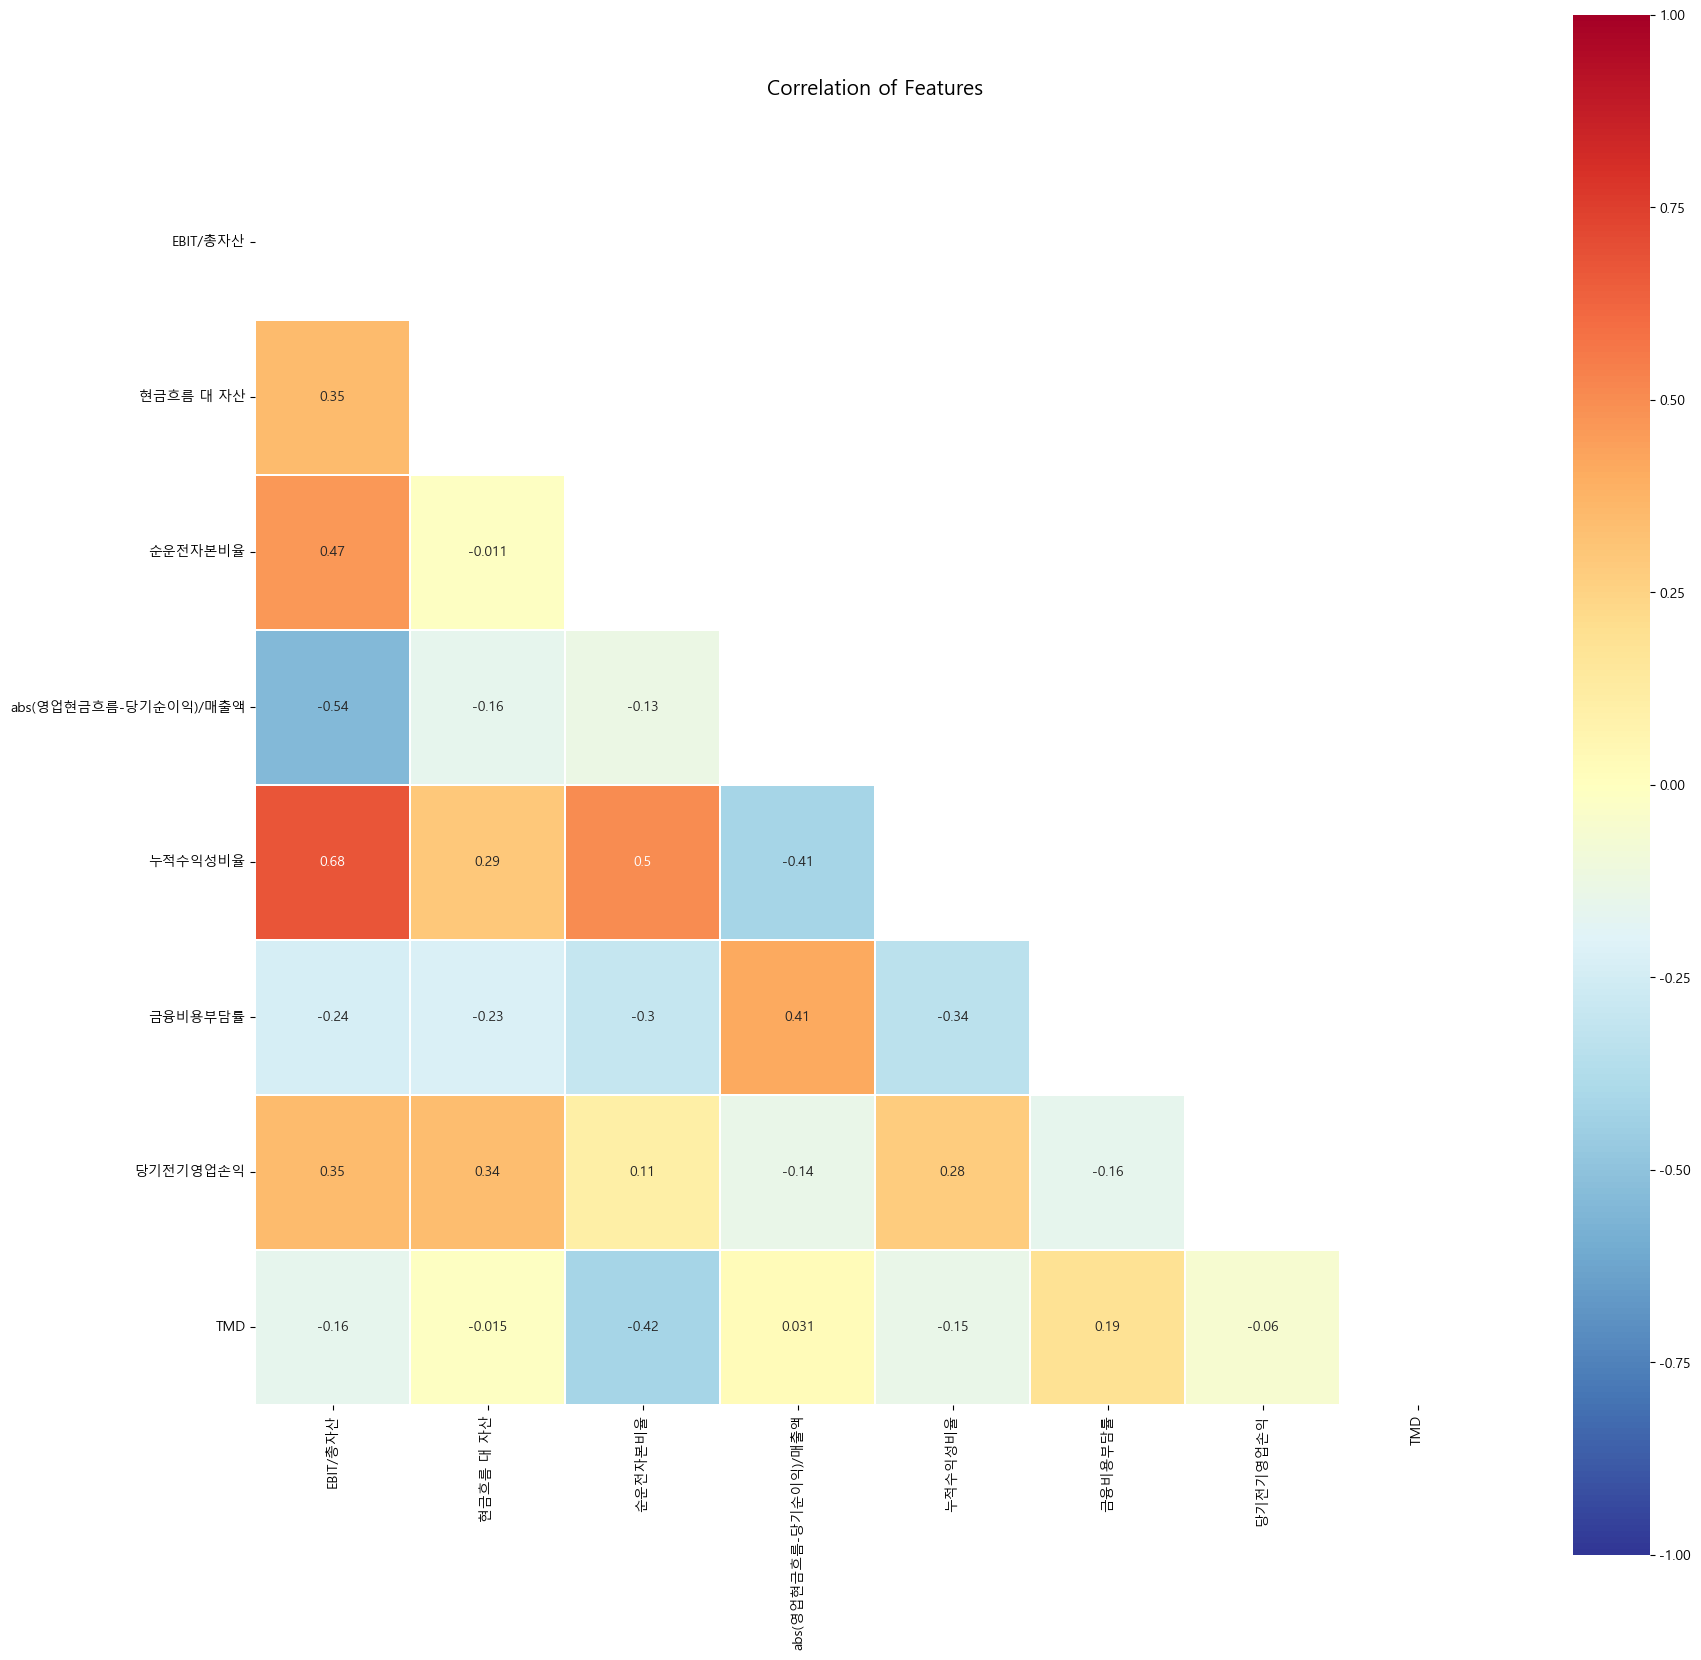

In [135]:
colormap = plt.cm.hot

corr = x_train_1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [136]:
model_basic(x_train_1,y_train,x_train_1,y_train)

[[4802   14]
 [  93   79]]
[[4788   28]
 [  97   75]]
[[4665  151]
 [  68  104]]
[[4816    0]
 [   0  172]]
[[4816    0]
 [   0  172]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9785,0.8495,0.4593,0.5962,0.9361
1,LinearDiscriminantAnalysis(),0.9749,0.7282,0.4360,0.5455,0.9353
2,GaussianNB(),0.9561,0.4078,0.6047,0.4871,0.9218
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [137]:
model_basic(x_train_1,y_train,x_test_1,y_test)

[[2793   18]
 [  31   44]]
[[2767   44]
 [  30   45]]
[[2668  143]
 [  16   59]]
[[2803    8]
 [  29   46]]
[[2798   13]
 [  33   42]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9830,0.7097,0.5867,0.6423,0.9461
1,LinearDiscriminantAnalysis(),0.9744,0.5056,0.6000,0.5488,0.9520
2,GaussianNB(),0.9449,0.2921,0.7867,0.4260,0.9621
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9872,0.8519,0.6133,0.7132,0.9546
4,"XGBClassifier(base_score=None, booster=None, c...",0.9841,0.7636,0.5600,0.6462,0.9523


-----
# target2

In [138]:
x_train = train[col_int]
y_train = train[['target_2']]

x_test = test[col_int]
y_test = test[['target_2']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_2 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_2.index = x_train.columns

In [139]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_2["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_2["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_2["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_2['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_2['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_2['RFC_bwd'] = selector.get_support().tolist()

In [140]:
for col in df_select_2.columns.to_list():
    df_select_2[col] = df_select_2[col].apply(lambda x : 1 if x==True else 0)
df_select_2['total'] = df_select_2.sum(axis=1)
df_select_2[df_select_2['total']>=5].index


Index(['EBIT/총자산', '현금흐름 대 자산', '순운전자본비율', '누적수익성비율', '총자본회전률', 'TMD',
       '매출액총이익률'],
      dtype='object')

In [141]:
df_select_2[df_select_2['total']>=5]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
EBIT/총자산,0,1,1,1,1,1,0,5
현금흐름 대 자산,0,1,1,1,1,0,1,5
순운전자본비율,0,1,1,1,1,0,1,5
누적수익성비율,1,1,1,1,1,0,1,6
총자본회전률,0,1,1,1,1,0,1,5
TMD,1,1,1,1,1,1,1,7
매출액총이익률,0,1,1,0,1,1,1,5


In [142]:
최종_col =df_select_2[df_select_2['total']>=5].index.to_list()

x_train_2 = x_train[최종_col]
x_test_2 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

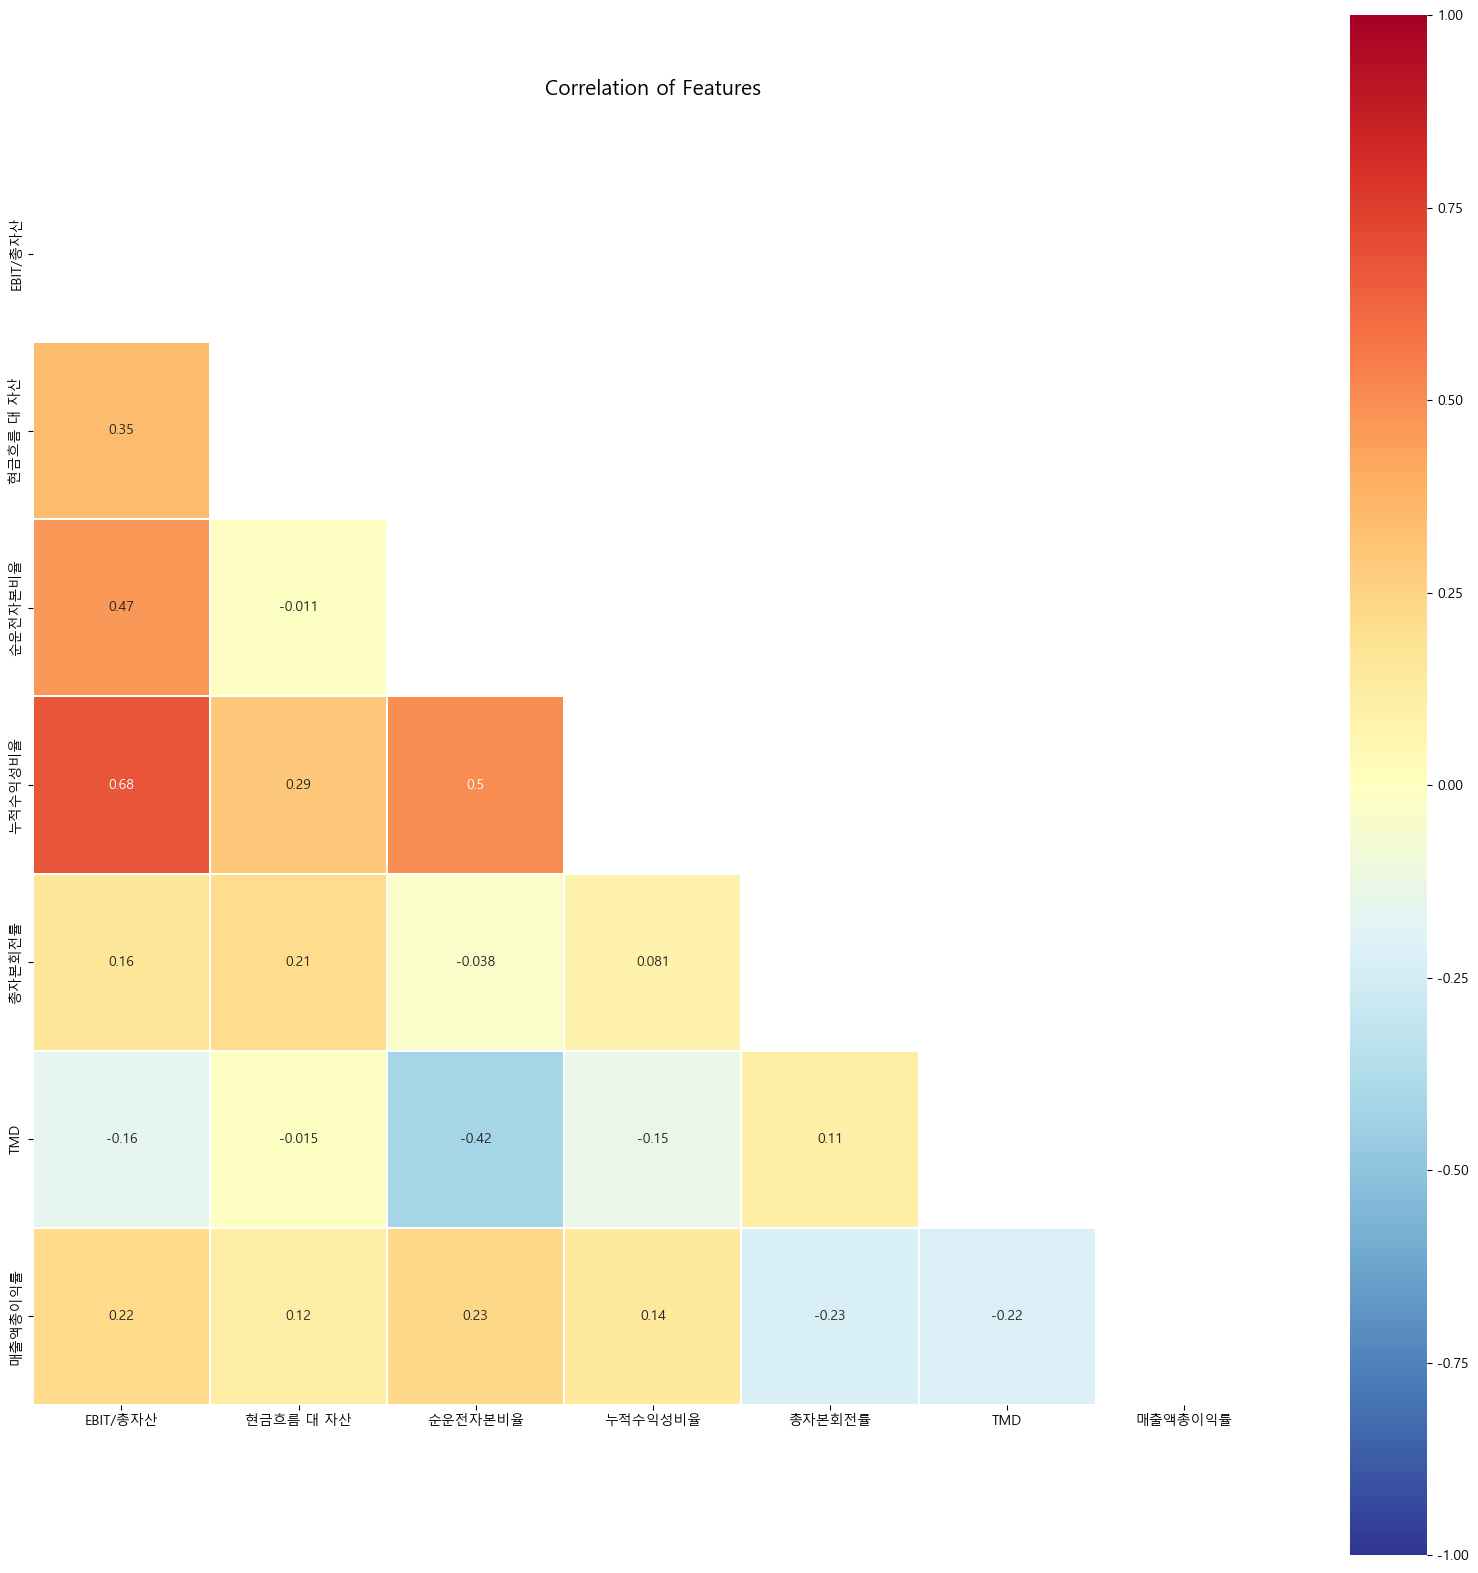

In [143]:
colormap = plt.cm.hot

corr = x_train_2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [144]:
model_basic(x_train_2,y_train,x_train_2,y_train)

[[4760   17]
 [ 133   78]]
[[4747   30]
 [ 132   79]]
[[4643  134]
 [ 102  109]]
[[4777    0]
 [   0  211]]
[[4777    0]
 [   0  211]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9699,0.8211,0.3697,0.5098,0.9167
1,LinearDiscriminantAnalysis(),0.9675,0.7248,0.3744,0.4937,0.9139
2,GaussianNB(),0.9527,0.4486,0.5166,0.4802,0.8880
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [145]:
model_basic(x_train_2,y_train,x_test_2,y_test)

[[2794   19]
 [  34   39]]
[[2773   40]
 [  35   38]]
[[2718   95]
 [  19   54]]
[[2801   12]
 [  34   39]]
[[2794   19]
 [  29   44]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9816,0.6724,0.5342,0.5954,0.9424
1,LinearDiscriminantAnalysis(),0.9740,0.4872,0.5205,0.5033,0.9456
2,GaussianNB(),0.9605,0.3624,0.7397,0.4865,0.9658
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9841,0.7647,0.5342,0.6290,0.9672
4,"XGBClassifier(base_score=None, booster=None, c...",0.9834,0.6984,0.6027,0.6471,0.9562


----
# target3

In [146]:
x_train = train[col_int]
y_train = train[['target_3']]

x_test = test[col_int]
y_test = test[['target_3']]

#  선정된 피쳐를 저장하기 위한 데이터프레임 생성 
df_select_3 = pd.DataFrame()
# 생성된 데이터프레임의 인덱스 지정
df_select_3.index = x_train.columns

In [147]:
#  lasso
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.01)).fit(x_train, y_train)
df_select_3["lasso_0.01"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.05)).fit(x_train, y_train)
df_select_3["lasso_0.05"] = selector.get_support()

selector = SelectFromModel(estimator=LogisticRegression(penalty='l1',solver='liblinear',C=0.1)).fit(x_train, y_train)
df_select_3["lasso_0.1"] = selector.get_support()

# logit foward
estimator = LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_fwd'] = selector.get_support().tolist()
# logit backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['logit_bwd'] = selector.get_support().tolist()


# lda foward
estimator = LinearDiscriminantAnalysis(solver='svd')
selector = SequentialFeatureSelector(estimator,direction='forward',cv=5,n_jobs=-1)
selector.fit(x_train, y_train)
df_select_3['lda_fwd'] = selector.get_support().tolist()
# lda backward
selector = SequentialFeatureSelector(estimator,direction='backward',cv=5,n_jobs=-1,)
selector.fit(x_train, y_train)
df_select_3['lda_bwd'] = selector.get_support().tolist()

# # RandomForest_foward
# estimator = RandomForestClassifier()
# selector = SequentialFeatureSelector(estimator,direction='forward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_fwd'] = selector.get_support().tolist()
# # RandomForest _ backward
# selector = SequentialFeatureSelector(estimator,direction='backward',cv=2,n_jobs=-1)
# selector.fit(x_train, y_train)
# df_select_3['RFC_bwd'] = selector.get_support().tolist()

In [159]:
for col in df_select_3.columns.to_list():
    df_select_3[col] = df_select_3[col].apply(lambda x : 1 if x==True else 0)
df_select_3['total'] = df_select_3.sum(axis=1)
df_select_3[df_select_3['total']>=5].index

Index(['EBIT/총자산', 'abs(영업현금흐름-당기순이익)/매출액', '누적수익성비율', '총자본회전률', '금융비용부담률',
       '당기전기영업손익', 'TMD'],
      dtype='object')

In [149]:
df_select_3[(df_select_3['total']>=5) ]

,lasso_0.01,lasso_0.05,lasso_0.1,logit_fwd,logit_bwd,lda_fwd,lda_bwd,total
EBIT/총자산,0,1,1,1,1,1,0,5
abs(영업현금흐름-당기순이익)/매출액,1,1,1,0,1,0,1,5
누적수익성비율,1,1,1,0,1,1,1,6
총자본회전률,0,1,1,0,1,1,1,5
금융비용부담률,1,1,1,1,1,0,0,5
당기전기영업손익,0,1,1,1,1,1,0,5
TMD,1,1,1,1,1,1,1,7


In [150]:
최종_col =df_select_3[df_select_3['total']>=5].index.to_list()

x_train_3 = x_train[최종_col]
x_test_3 = x_test[최종_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

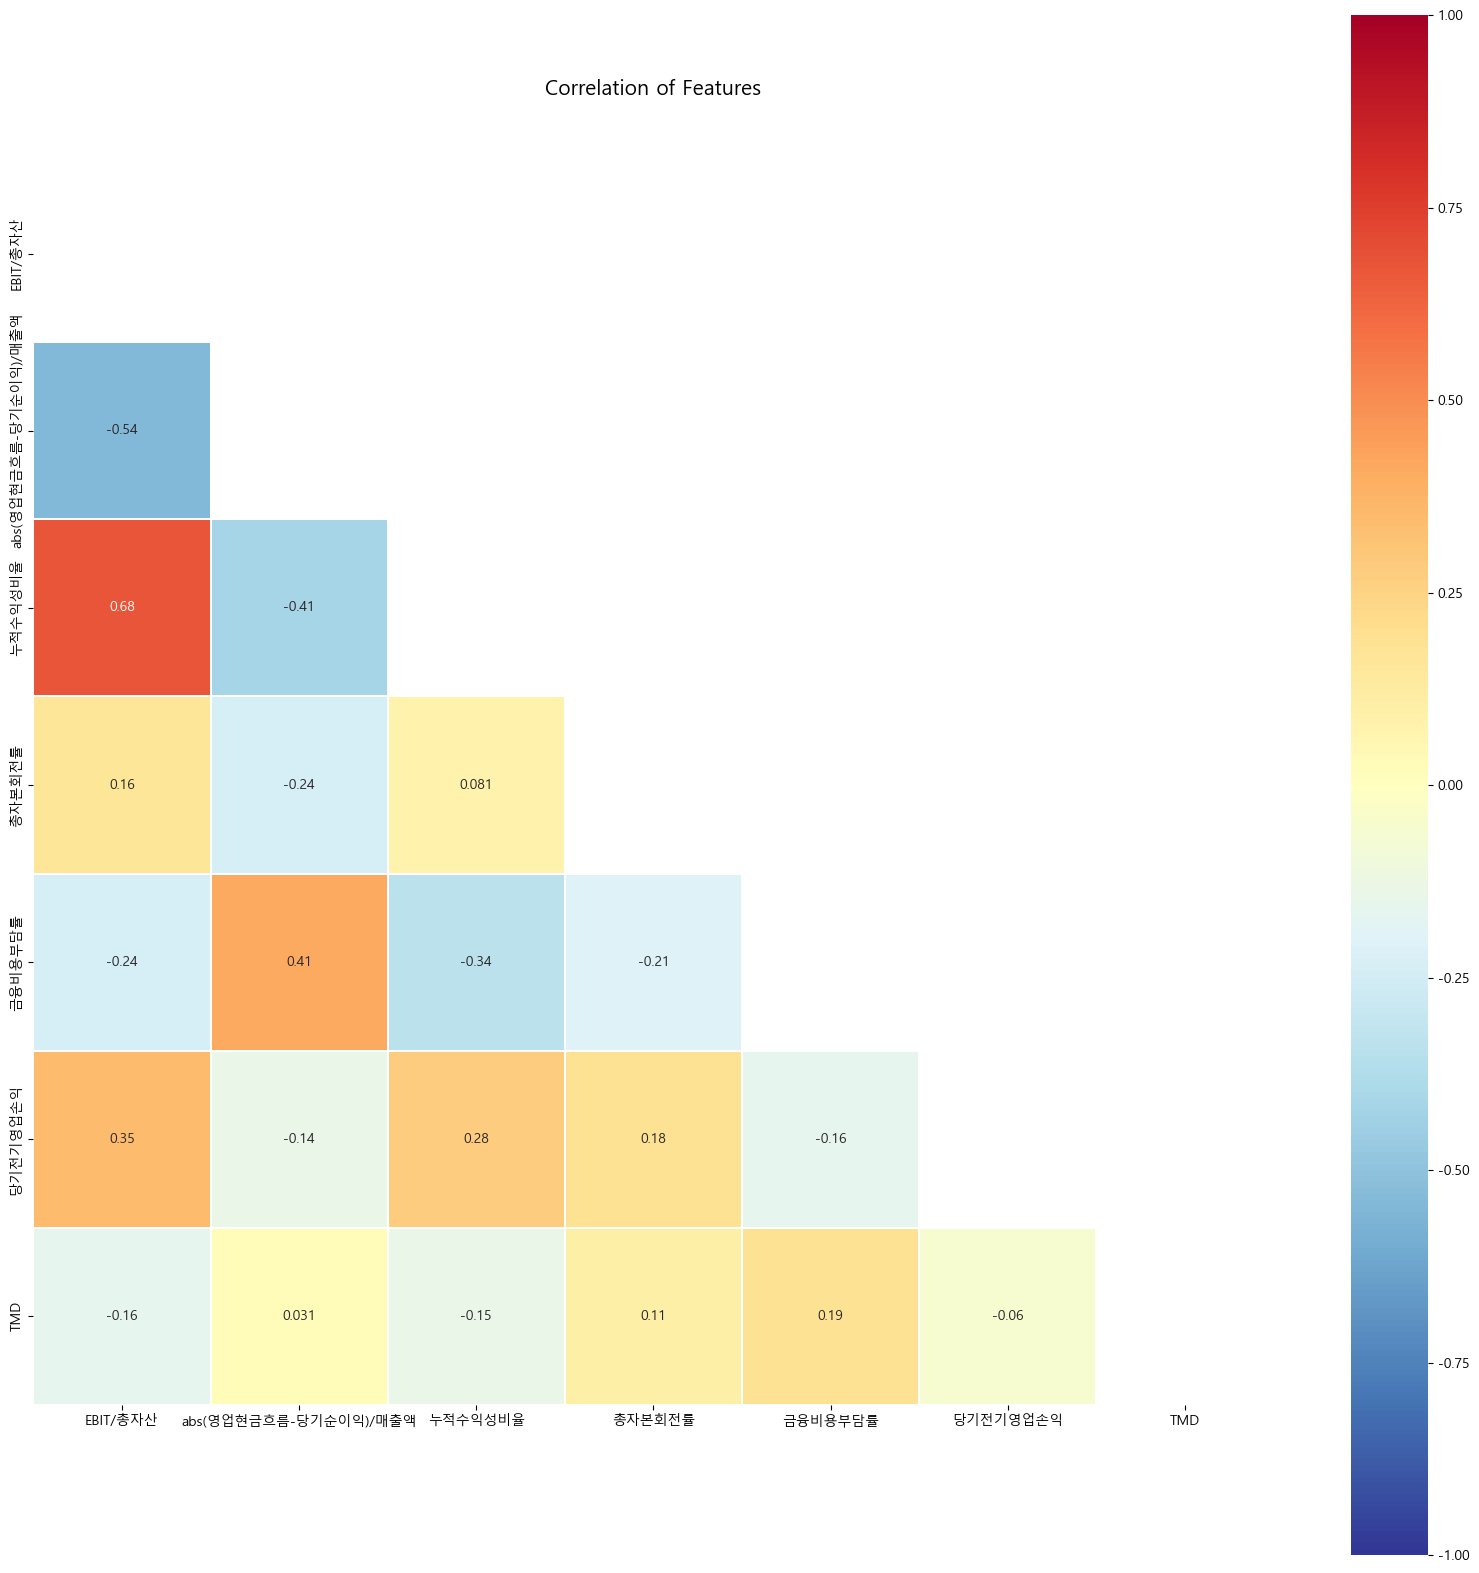

In [151]:
colormap = plt.cm.hot

corr = x_train_3.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [152]:
model_basic(x_train_3,y_train,x_train_3,y_train)

[[4811   12]
 [  92   73]]
[[4799   24]
 [  95   70]]
[[4668  155]
 [  66   99]]
[[4823    0]
 [   0  165]]
[[4823    0]
 [   0  165]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9791,0.8588,0.4424,0.5840,0.9411
1,LinearDiscriminantAnalysis(),0.9761,0.7447,0.4242,0.5405,0.9358
2,GaussianNB(),0.9557,0.3898,0.6000,0.4726,0.9304
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [153]:
model_basic(x_train_3,y_train,x_test_3,y_test)

[[2793   21]
 [  27   45]]
[[2773   41]
 [  27   45]]
[[2662  152]
 [  13   59]]
[[2802   12]
 [  32   40]]
[[2802   12]
 [  36   36]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9834,0.6818,0.6250,0.6522,0.9513
1,LinearDiscriminantAnalysis(),0.9764,0.5233,0.6250,0.5696,0.9608
2,GaussianNB(),0.9428,0.2796,0.8194,0.4170,0.9681
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9848,0.7692,0.5556,0.6452,0.9674
4,"XGBClassifier(base_score=None, booster=None, c...",0.9834,0.7500,0.5000,0.6000,0.9552


-----------------------


In [154]:

last_col = ['자기자본순이익률', 'EBITDA마진율', '누적수익성비율', '당기전기영업손익', '총자본증가율',
       'abs(영업현금흐름-당기순이익)/매출액', 'TMD','금융비용부담률']
x_train_3 = x_train[last_col]
x_test_3 = x_test[last_col]

<AxesSubplot:title={'center':'Correlation of Features'}>

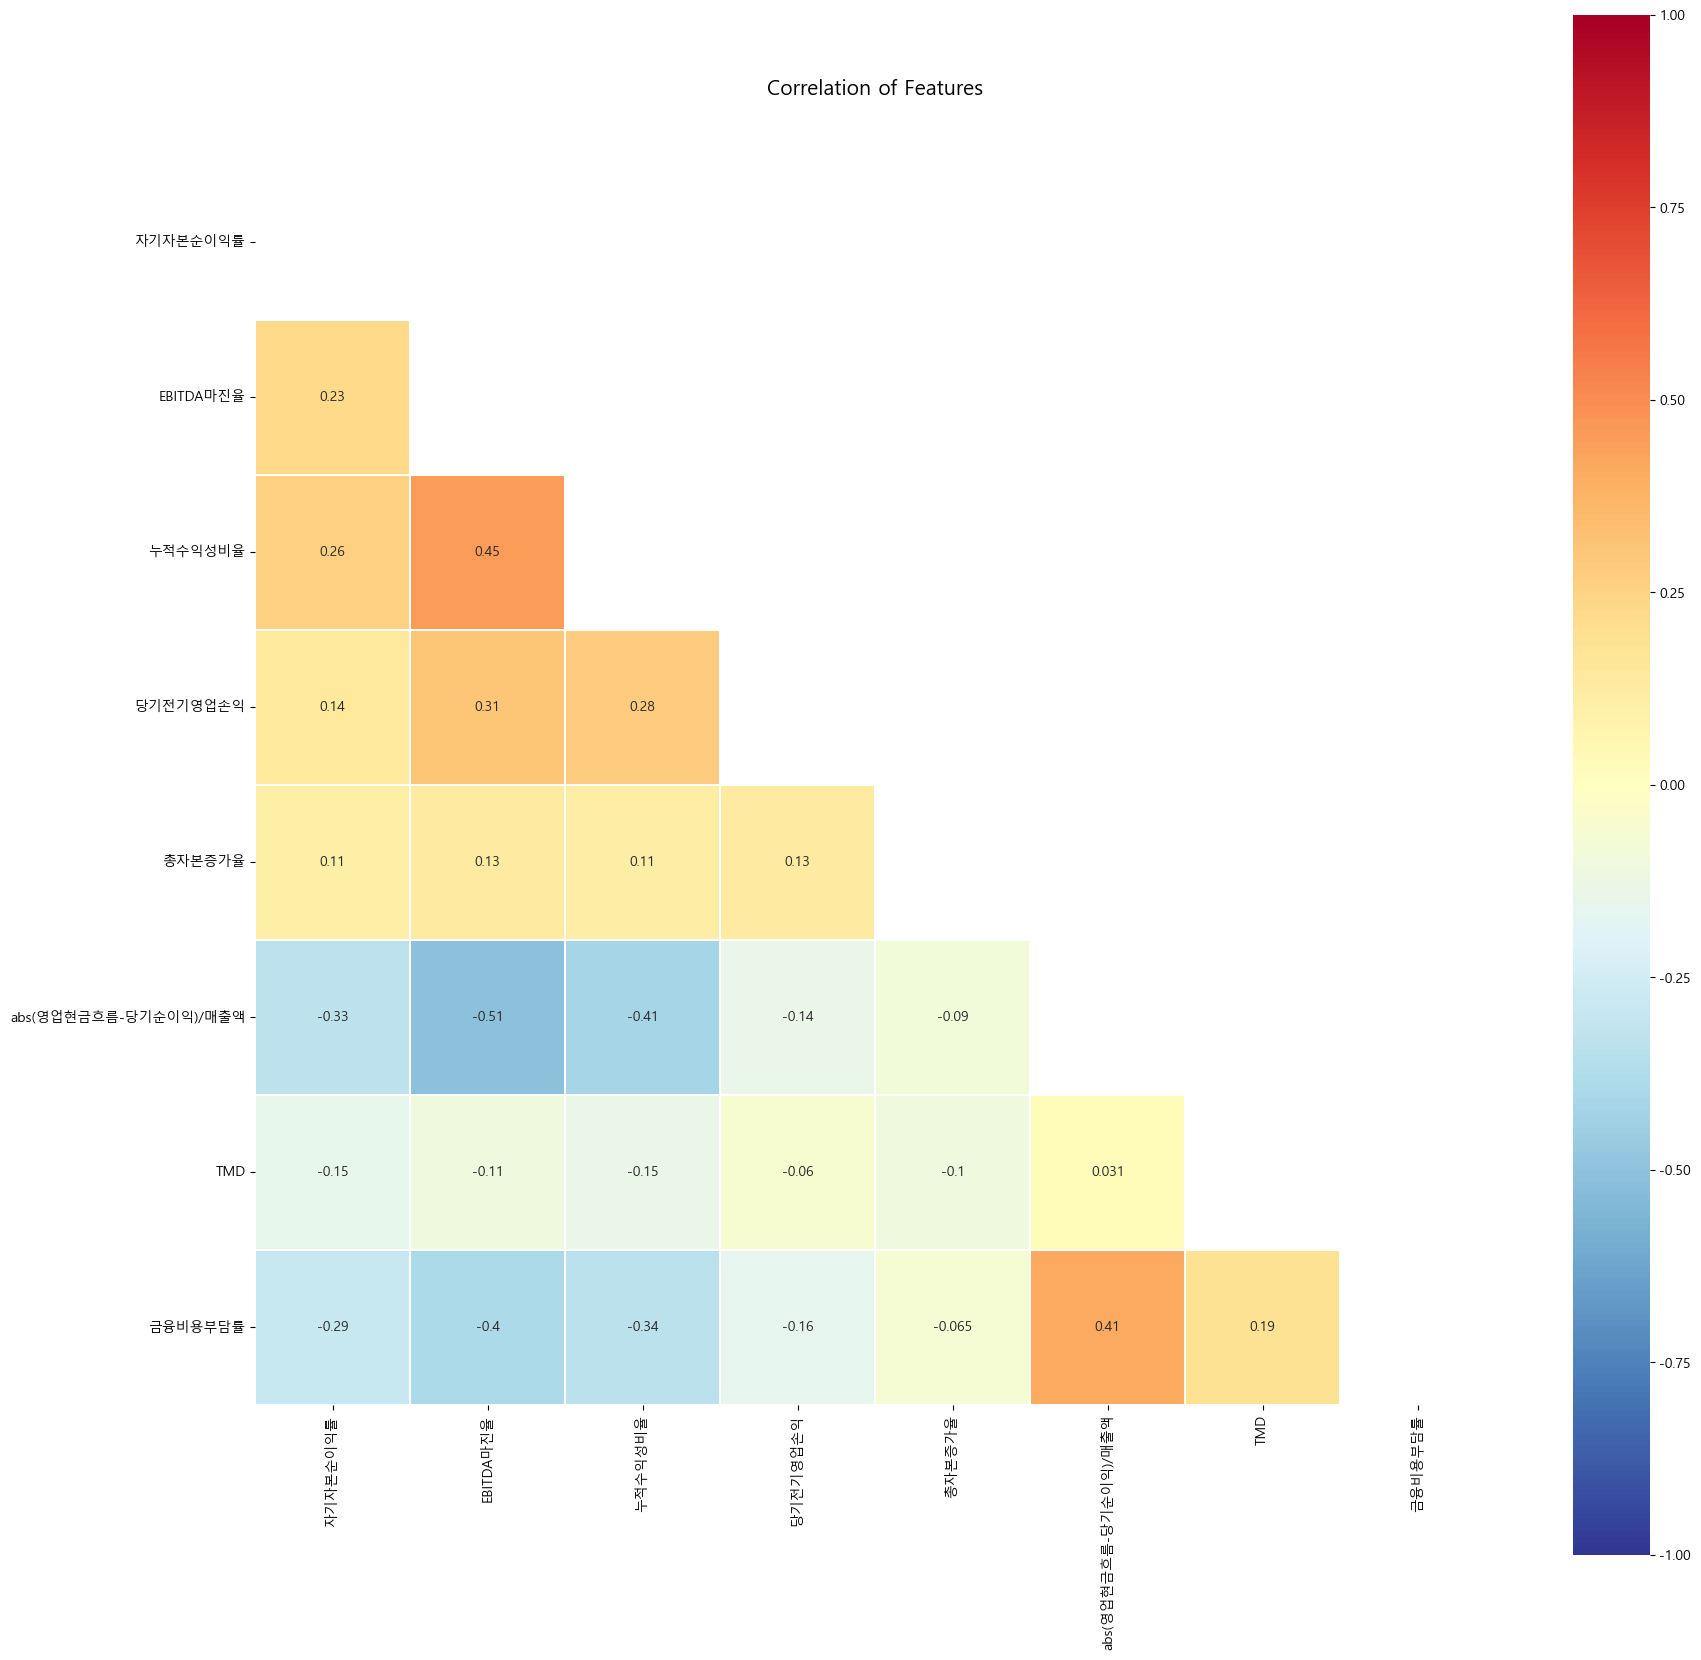

In [155]:
colormap = plt.cm.hot

corr = x_train_3.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="Malgun Gothic")
plt.title("Correlation of Features", y=1.05, size=15)
sns.heatmap(corr,  linewidths=0.1, vmax=1.0, vmin=-1.0, square=True,mask=mask,
            cmap='RdYlBu_r', linecolor="white", annot=True, annot_kws={'size': 10})

In [156]:
model_basic(x_train_3,y_train,x_train_3,y_train)

[[4809   14]
 [  92   73]]
[[4800   23]
 [  93   72]]
[[4651  172]
 [  53  112]]
[[4823    0]
 [   0  165]]
[[4823    0]
 [   0  165]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9787,0.8391,0.4424,0.5794,0.9387
1,LinearDiscriminantAnalysis(),0.9767,0.7579,0.4364,0.5538,0.9266
2,GaussianNB(),0.9549,0.3944,0.6788,0.4989,0.9304
3,"(DecisionTreeClassifier(max_features='sqrt', r...",1.0000,1.0000,1.0000,1.0000,1.0000
4,"XGBClassifier(base_score=None, booster=None, c...",1.0000,1.0000,1.0000,1.0000,1.0000


In [157]:
model_basic(x_train_3,y_train,x_test_3,y_test)

[[2793   21]
 [  30   42]]
[[2769   45]
 [  24   48]]
[[2651  163]
 [  13   59]]
[[2797   17]
 [  26   46]]
[[2790   24]
 [  27   45]]


,model,accuracy,precision,recall,f1_score,auc_score
0,LogisticRegression(),0.9823,0.6667,0.5833,0.6222,0.9637
1,LinearDiscriminantAnalysis(),0.9761,0.5161,0.6667,0.5818,0.9691
2,GaussianNB(),0.9390,0.2658,0.8194,0.4014,0.9642
3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.9851,0.7302,0.6389,0.6815,0.9600
4,"XGBClassifier(base_score=None, booster=None, c...",0.9823,0.6522,0.6250,0.6383,0.9532
